<a href="https://colab.research.google.com/github/hsuanchengsun/Natural-Language-Processing/blob/main/Text_Classification_by_SVM_and_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Classifiers with BOW

In [ ]:
# Automatically mount google drive using the file browser 
# or mount google drive using code below
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# required packages
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

import numpy as np
np.random.seed()
import random
random.seed()

## 1.1 BOW feature set

In [ ]:
# read the csv file with BOW features into Pandas DataFrame
df_bow = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_BOW.csv', index_col = 0)
df_bow.head(3)

,reviewID,Resturant,Zipcode,City,State,Business_Rating_Score,Review,Review_expanded,Review_Token,Review_tagged,...,old,egg,perfect,line,overall,actually,cream,let,busy,steak
0,0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,The ambience is kind of funky & interesting. F...,The ambience is kind of funky & interesting. F...,"['The', 'ambience', 'is', 'kind', 'of', 'funky...","[('The', 'DT'), ('ambience', 'NN'), ('is', 'VB...",...,2,1,3,1,5,5,3,4,5,0
1,1,21 Nickels,02472,Watertown,MA,4.0,I like 21 Nickels a ton and they'd attract mor...,I like 21 Nickels a ton and they would attract...,"['I', 'like', '21', 'Nickels', 'a', 'ton', 'an...","[('I', 'PRP'), ('like', 'VBP'), ('21', 'CD'), ...",...,9,7,7,3,5,5,2,8,4,11
2,2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,This place needs to be shut down. I couldn't b...,This place needs to be shut down. I could not ...,"['This', 'place', 'needs', 'to', 'be', 'shut',...","[('This', 'DT'), ('place', 'NN'), ('needs', 'V...",...,2,0,0,0,0,2,0,1,1,0


In [ ]:
# Check total rows
print('Number of rows: ', len(df_bow))

Number of rows:  1075


In [ ]:
# Let's create a binary target; these with a review rating score 4 and 5 are 1, and 3 or less are 0.  

df_bow['Target'] = df_bow['Business_Rating_Score'].apply(lambda x:1 if x >= 4 else 0)
df_bow['Target'].value_counts()

0    660
1    415
Name: Target, dtype: int64

In [ ]:
# Check the number of input components
df_bow.columns[13:]

Index(['food', 'good', 'place', 'get', 'order', 'time', 'like', 'great',
       'would', 'come',
       ...
       'egg', 'perfect', 'line', 'overall', 'actually', 'cream', 'let', 'busy',
       'steak', 'Target'],
      dtype='object', length=201)

In [ ]:
# Test/train split (full feature set)
from sklearn.model_selection import train_test_split

# Straified sampling
X_train, X_test, y_train, y_test = train_test_split(df_bow.drop(['Target'],axis =1).iloc[:, 13:], 
                                                    df_bow['Target'], stratify=df_bow['Target'],
                                                    test_size=0.2, random_state=101) 

print("The length of training set:", len(X_train))
print("The shape of training/test feature set:", X_train.shape)
print("The length of testing  set:", len(X_test))

The length of training set: 860
The shape of training/test feature set: (860, 200)
The length of testing  set: 215


## 1.2 SVM

In [ ]:
# use GridsearchCV tuning the hyper-parameter

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_SVM(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10, random_state = 4561, shuffle = True) 
    grid_search = GridSearchCV(SVC(), param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs = -1, verbose =1)
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf',  'poly', 'sigmoid']} 
%time grid_search_SVM(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best score: 0.837
Best parameters set:
	C: 0.1
	gamma: 1
	kernel: 'poly'
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       132
           1       0.84      0.76      0.80        83

    accuracy                           0.85       215
   macro avg       0.85      0.83      0.84       215
weighted avg       0.85      0.85      0.85       215

CPU times: user 1.67 s, sys: 117 ms, total: 1.79 s
Wall time: 29.7 s


In [ ]:
# Use the tuned hyper-parameter to fit the model
clf_svm = SVC(C = 0.1, gamma = 1, kernel = 'poly')

%time clf_svm.fit (X_train, y_train)
print(clf_svm.score (X_test ,y_test))

y_predict = clf_svm.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 45.9 ms, sys: 1.06 ms, total: 47 ms
Wall time: 49.1 ms
0.8511627906976744


,Predicted Not Good,Predicted Good
True Not Good,120,12
True Good,20,63


In [ ]:
# append the result to performance table
fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table_bow  = {}
scores = dict()
scores['precision'] = precision_score(y_test, y_predict)
scores['recall'] = recall_score(y_test, y_predict)
scores['accuracy'] = accuracy_score(y_test, y_predict)
scores['f1'] = f1_score(y_test, y_predict)
table_bow['SVM with full bow feature set'] = scores

## 1.3 Gradient Boosting

In [ ]:
# Explore Decision Tree basedline models based on the depth of the tree
# the performance plateaued at the depth of 4
crossvalidation=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
for depth in range (1,20):
    tree_classifier=tree.DecisionTreeClassifier(max_depth=depth,random_state=1)
    if tree_classifier.fit(X_train,y_train).tree_.max_depth<depth:
        break
    score=np.mean(cross_val_score(tree_classifier,X_train,y_train,scoring='accuracy', cv=crossvalidation,n_jobs=1))
    print(depth, score)


1 0.7430232558139535
2 0.7709302325581395
3 0.7813953488372093
4 0.8162790697674419
5 0.7848837209302325
6 0.7872093023255815
7 0.7767441860465116
8 0.7732558139534884
9 0.7651162790697674
10 0.7662790697674419
11 0.7674418604651162
12 0.7639534883720931
13 0.7616279069767442
14 0.7651162790697674


In [ ]:
# we can also use leaf size to select the baseline Tree model
# if use the minimal size per leaf, the best leaf size is 20. 
crossvalidation=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

for leafsize in range (20,42,2): # step is 2
    tree_classifier=tree.DecisionTreeClassifier(min_samples_leaf=leafsize,random_state=1)
    score=np.mean(cross_val_score(tree_classifier,X_train,y_train,scoring='accuracy', cv=crossvalidation,n_jobs=1))
    print(leafsize, score)

20 0.786046511627907
22 0.7616279069767442
24 0.7674418604651163
26 0.7825581395348837
28 0.7744186046511627
30 0.7767441860465116
32 0.7813953488372093
34 0.7825581395348837
36 0.7790697674418604
38 0.7813953488372093
40 0.7779069767441861


In [ ]:
# Use the best leaf size (min_samples_leaf) 20 to build the baseline model

def grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """   
    grad = GradientBoostingClassifier(min_samples_leaf =20, random_state = 2541)
    grid_search = GridSearchCV(grad, param_grid, scoring=scorers, refit=refit_score, 
                               cv=10, return_train_score=True, n_jobs = -1, verbose =1)
    
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators' : [100, 200, 500],
    'max_features' : ['sqrt', 'log2']
}

%time grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.888
Best parameters set:
	learning_rate: 0.1
	max_features: 'log2'
	n_estimators: 200
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       132
           1       0.92      0.80      0.85        83

    accuracy                           0.89       215
   macro avg       0.90      0.87      0.88       215
weighted avg       0.89      0.89      0.89       215

CPU times: user 1.49 s, sys: 123 ms, total: 1.61 s
Wall time: 53.7 s


In [ ]:
# Use the tuned hyper-parameter to fit the model

clf_grad = GradientBoostingClassifier(min_samples_leaf =20, n_estimators = 200, learning_rate = 0.1, 
                                      max_features = 'log2', random_state = 2541) # add random state to control for reproducible output
%time clf_grad.fit(X_train,y_train)
# Predict Performance
print(clf_grad.score (X_test ,y_test))

y_predict = clf_grad.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 273 ms, sys: 0 ns, total: 273 ms
Wall time: 276 ms
0.8930232558139535


,Predicted Not Good,Predicted Good
True Not Good,126,6
True Good,17,66


In [ ]:
# append the result to performance table

scores = {'precision': precision_score(y_test, y_predict),
          'recall': recall_score(y_test, y_predict),
          'accuracy':accuracy_score(y_test, y_predict),
          'f1': f1_score(y_test, y_predict)}
table_bow['Gradient Boosting with full bow feature set'] = scores

In [ ]:
# convert out performance dictionary to dataframe and take a look
bow_performance = pd.DataFrame(table_bow).T[['accuracy','recall', 'precision', 'f1']]  # transpose and reorder the dataframe
bow_performance

,accuracy,recall,precision,f1
SVM with full bow feature set,0.851163,0.759036,0.840000,0.797468
Gradient Boosting with full bow feature set,0.893023,0.795181,0.916667,0.851613


The best model here would be the gradient boosting approach. Every index of it is higher than SVM's and they show that gradient boosting has better performance than SVM. 

# Section 2: Classifiers with Word2vec with or without SVD

In [ ]:
# Automatically mount google drive using the file browser 
# or mount google drive using code below
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Mounted at /content/drive


In [ ]:
# required packages
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

import numpy as np
np.random.seed()
import random
random.seed()

## 2.1 Doc2Vec feature set


In [ ]:
# read the csv file with AWE features into Pandas DataFrame
df_AWE = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_AWE_groupby.csv')
df_AWE.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,AWE1,AWE2,AWE3,AWE4,AWE5,...,AWE291,AWE292,AWE293,AWE294,AWE295,AWE296,AWE297,AWE298,AWE299,AWE300
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,-0.004233,0.003970,0.014558,0.007793,-0.013913,...,-0.004434,0.014302,-0.024087,0.002030,0.007161,-0.007361,0.001872,-0.008344,-0.008499,-0.005230
1,21 Nickels,02472,Watertown,MA,4.0,-0.008349,0.002013,0.016399,0.006510,-0.015617,...,0.003085,0.015425,-0.022232,0.002130,0.005787,-0.009329,0.001661,-0.003716,-0.010980,-0.004237
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,-0.005781,0.005477,0.007118,0.006436,-0.009295,...,0.001349,0.007803,-0.024818,0.003353,0.006289,-0.012131,-0.000909,-0.009797,-0.013009,-0.008563


In [ ]:
print('Number of rows: ', len(df_AWE))

Number of rows:  1075


In [ ]:
# Let's create a binary target; these with a review rating score 4 and 5 are 1, and 3 or less are 0.  

df_AWE['Target'] = df_AWE['Business_Rating_Score'].apply(lambda x:1 if x >= 4 else 0)
df_AWE['Target'].value_counts()

0    660
1    415
Name: Target, dtype: int64

In [ ]:
# Check the number of input components
df_AWE.columns[5:]

Index(['AWE1', 'AWE2', 'AWE3', 'AWE4', 'AWE5', 'AWE6', 'AWE7', 'AWE8', 'AWE9',
       'AWE10',
       ...
       'AWE292', 'AWE293', 'AWE294', 'AWE295', 'AWE296', 'AWE297', 'AWE298',
       'AWE299', 'AWE300', 'Target'],
      dtype='object', length=301)

In [ ]:
# Test/train split (full feature set)
from sklearn.model_selection import train_test_split

# Straified sampling
X_train, X_test, y_train, y_test = train_test_split(df_AWE.drop(['Target'],axis =1).iloc[:, 5:], 
                                                    df_AWE['Target'], stratify=df_AWE['Target'],
                                                    test_size=0.2, random_state=101) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print("The length of training set:", len(X_train))
print("The shape of training/test feature set:", X_train.shape)
print("The length of testing  set:", len(X_test))

The length of training set: 860
The shape of training/test feature set: (860, 300)
The length of testing  set: 215


## 2.2 SVM without SVD

In [ ]:
# use GridsearchCV tuning the hyper-parameter

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_SVM(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10, random_state = 4561, shuffle = True) 
    grid_search = GridSearchCV(SVC(), param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs = -1, verbose =1)
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf',  'poly', 'sigmoid']} 
%time grid_search_SVM(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best score: 0.823
Best parameters set:
	C: 10
	gamma: 1
	kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       132
           1       0.89      0.67      0.77        83

    accuracy                           0.84       215
   macro avg       0.86      0.81      0.82       215
weighted avg       0.85      0.84      0.84       215

CPU times: user 1.91 s, sys: 126 ms, total: 2.04 s
Wall time: 43.4 s


In [ ]:
# Use the tuned hyper-parameter to fit the model
clf_svm = SVC(C = 10, gamma = 1, kernel = 'rbf')

%time clf_svm.fit (X_train, y_train)
print(clf_svm.score (X_test ,y_test))

y_predict = clf_svm.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 94.4 ms, sys: 1.91 ms, total: 96.4 ms
Wall time: 98.2 ms
0.8418604651162791


,Predicted Not Good,Predicted Good
True Not Good,125,7
True Good,27,56


In [ ]:
# append the result to performance table
fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table_AWE  = {}
scores = dict()
scores['precision'] = precision_score(y_test, y_predict)
scores['recall'] = recall_score(y_test, y_predict)
scores['accuracy'] = accuracy_score(y_test, y_predict)
scores['f1'] = f1_score(y_test, y_predict)
table_AWE['SVM with AWE feature set'] = scores

## 2.3 SVD for dimensionality reduction

In [ ]:
# determine the number of SVD features to keep 
from sklearn.decomposition import TruncatedSVD

X = df_AWE.drop(['Target'],axis =1).iloc[:, 5:]

var_explained = []
for i in range(2, 300):
  svd = TruncatedSVD(n_components= i)
  svd.fit(X) 
  var_explained.append(svd.explained_variance_ratio_.sum())

Text(0, 0.5, 'Total variance explained')

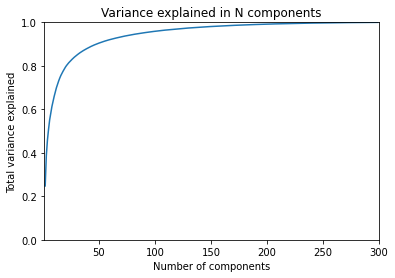

In [ ]:
import matplotlib.pyplot as plt

# Plot the variance explained 
x_axis = [i for i in range(2, 300)]
plt.plot(x_axis, var_explained)
plt.axis ([1, 300, 0, 1])
plt.title("Variance explained in N components")
plt.xlabel("Number of components")
plt.ylabel("Total variance explained")

In [ ]:
# determining the number of components with a threshold if variance explained ≥0.9

n = 0
for i in range(len(var_explained)):
  if var_explained[i] >= 0.9:
    n = i
    break
print("The Least Number of Components if Variance Explained ≥ 0.9:", n)

The Least Number of Components if Variance Explained ≥ 0.9: 46


In [ ]:
# Based on the graph above, we chose to reduce the original input features to 46 SVs
svd = TruncatedSVD(n_components= 46)
svd.fit(X)
X_svd = svd.transform(X)
X_svd.shape

(1075, 46)

In [ ]:
# Test/train split (reduced feature set)
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, 
                                                    df_AWE['Target'], stratify=df_AWE['Target'],
                                                    test_size=0.2, random_state=101) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print("The length of training set:", len(X_train_svd))
print("The shape of training/test feature set:", X_train_svd.shape)
print("The length of testing  set:", len(X_test_svd))

The length of training set: 860
The shape of training/test feature set: (860, 46)
The length of testing  set: 215


## 2.4 SVM with SVD

In [ ]:
# Similarly, use GridsearchCV tuning hyper-parameter after SVD

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']} 

%time grid_search_SVM(X_train_svd, X_test_svd, y_train_svd, y_test_svd, param_grid)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best score: 0.873
Best parameters set:
	C: 100
	gamma: 1
	kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       132
           1       0.89      0.77      0.83        83

    accuracy                           0.87       215
   macro avg       0.88      0.86      0.86       215
weighted avg       0.88      0.87      0.87       215

CPU times: user 2.02 s, sys: 90.9 ms, total: 2.11 s
Wall time: 37.9 s


In [ ]:
# Use the tuned hyper-parameter to fit the model
clf_svm_svd = SVC(C = 100, gamma = 1, kernel = 'rbf')

%time clf_svm_svd.fit (X_train_svd, y_train_svd)
print(clf_svm_svd.score (X_test_svd ,y_test_svd))

y_predict = clf_svm_svd.predict(X_test_svd)
pd.DataFrame(    
             confusion_matrix(y_test_svd, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 45.1 ms, sys: 0 ns, total: 45.1 ms
Wall time: 47.3 ms
0.8744186046511628


,Predicted Not Good,Predicted Good
True Not Good,124,8
True Good,19,64


In [ ]:
# append the result to performance table
scores = {'precision': precision_score(y_test_svd, y_predict),
          'recall': recall_score(y_test_svd, y_predict),
          'accuracy':accuracy_score(y_test_svd, y_predict),
          'f1': f1_score(y_test_svd, y_predict)}
table_AWE['SVM with TruncatedSVD AWE feature set'] = scores

## 2.5 Gradient Boosting witout SVD

In [ ]:
# Use the best leaf size (min_samples_leaf) 20 to build the baseline model

def grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """   
    grad = GradientBoostingClassifier(min_samples_leaf =20, random_state = 2541)
    grid_search = GridSearchCV(grad, param_grid, scoring=scorers, refit=refit_score, 
                               cv=10, return_train_score=True, n_jobs = -1, verbose =1)
    
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators' : [100, 200, 500],
    'max_features' : ['sqrt', 'log2']
}

%time grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.887
Best parameters set:
	learning_rate: 0.1
	max_features: 'sqrt'
	n_estimators: 500
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       132
           1       0.90      0.75      0.82        83

    accuracy                           0.87       215
   macro avg       0.88      0.85      0.86       215
weighted avg       0.87      0.87      0.87       215

CPU times: user 4.56 s, sys: 80 ms, total: 4.64 s
Wall time: 1min 58s


In [ ]:
# Use the tuned hyper-parameter to fit the model

clf_grad = GradientBoostingClassifier(min_samples_leaf =20, n_estimators = 500, learning_rate = 0.1, 
                                      max_features = 'sqrt', random_state = 2541) # add random state to control for reproducible output
%time clf_grad.fit(X_train,y_train)
# Predict Performance
print(clf_grad.score (X_test ,y_test))

y_predict = clf_grad.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 3.3 s, sys: 1.31 ms, total: 3.3 s
Wall time: 3.38 s
0.8697674418604651


,Predicted Not Good,Predicted Good
True Not Good,125,7
True Good,21,62


In [ ]:
scores = {'precision': precision_score(y_test, y_predict),
          'recall': recall_score(y_test, y_predict),
          'accuracy':accuracy_score(y_test, y_predict),
          'f1': f1_score(y_test, y_predict)}
table_AWE['Gradient Boosting with AWE feature set'] = scores

## 2.6 Gradient Boosting with SVD

In [ ]:
# hyper-parameter tuning 

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators' : [100, 200, 500],
    'max_features' : ['sqrt', 'log2']
}

%time grid_search_grad_boost(X_train_svd, X_test_svd, y_train_svd, y_test_svd, param_grid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.845
Best parameters set:
	learning_rate: 0.1
	max_features: 'log2'
	n_estimators: 200
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       132
           1       0.87      0.66      0.75        83

    accuracy                           0.83       215
   macro avg       0.84      0.80      0.81       215
weighted avg       0.84      0.83      0.83       215

CPU times: user 1.54 s, sys: 93.8 ms, total: 1.64 s
Wall time: 1min 6s


In [ ]:
# Use the tuned hyper-parameter to fit the model

clf_grad = GradientBoostingClassifier(min_samples_leaf =20, n_estimators = 200, learning_rate = 0.1, 
                                      max_features = 'log2', random_state = 2541) # add random state to control for reproducible output
%time clf_grad.fit(X_train_svd,y_train_svd)
# Predict Performance
print(clf_grad.score (X_test_svd,y_test_svd))

y_predict = clf_grad.predict(X_test_svd)
pd.DataFrame(    
             confusion_matrix(y_test_svd, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 374 ms, sys: 0 ns, total: 374 ms
Wall time: 375 ms
0.8325581395348837


,Predicted Not Good,Predicted Good
True Not Good,124,8
True Good,28,55


In [ ]:
scores = {'precision': precision_score(y_test_svd, y_predict),
          'recall': recall_score(y_test_svd, y_predict),
          'accuracy':accuracy_score(y_test_svd, y_predict),
          'f1': f1_score(y_test_svd, y_predict)}
table_AWE['Gradient Boosting with TruncatedSVD AWE feature set'] = scores

In [ ]:
# convert out performance dictionary to dataframe and take a look
AWE_performance = pd.DataFrame(table_AWE).T[['accuracy','recall', 'precision', 'f1']]  # transpose and reorder the dataframe
AWE_performance

,accuracy,recall,precision,f1
SVM with AWE feature set,0.841860,0.674699,0.888889,0.767123
SVM with TruncatedSVD AWE feature set,0.874419,0.771084,0.888889,0.825806
Gradient Boosting with AWE feature set,0.869767,0.746988,0.898551,0.815789
Gradient Boosting with TruncatedSVD AWE feature set,0.832558,0.662651,0.873016,0.753425


For the AWE feature set, the best model is SVM with truncated SVD. It has the best accuracy among others. Although its precision is slightly lower than the gradient boosting method, its recall and f1-score are all higher than gradient boosting. Therefore, SVM with truncated SVD is the best model here.

# Section 3: Classifiers with knowledge-based features

In [ ]:
# Automatically mount google drive using the file browser 
# or mount google drive using code below
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Mounted at /content/drive


In [ ]:
# required packages
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

import numpy as np
np.random.seed()
import random
random.seed()

## 3.1 NER tags and three sentiment analysis features 

In [ ]:
# read the csv file with NER features into Pandas DataFrame
df_ner = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_NER.csv', index_col = 0)
df_ner.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,Review,NER_ORG,NER_DATE,NER_Person
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,The ambience is kind of funky & interesting. F...,18,11,23
1,21 Nickels,02472,Watertown,MA,4.0,I like 21 Nickels a ton and they'd attract mor...,25,31,30
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,This place needs to be shut down. I couldn't b...,11,3,4


In [ ]:
print('Number of rows: ', len(df_ner))

Number of rows:  1075


In [ ]:
# read the csv file with NER features into Pandas DataFrame
df_sa = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_SA_groupby.csv')
df_sa.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,polarity,subjectivity,NLTK_Compound
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,0.165462,0.492290,0.471209
1,21 Nickels,02472,Watertown,MA,4.0,0.262287,0.572482,0.798269
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,-0.131477,0.569455,-0.302206


In [ ]:
print('Number of rows: ', len(df_sa))

Number of rows:  1075


In [ ]:
# merge two dataset to create the training data
df_language = pd.merge(df_ner, df_sa, how = 'inner', 
                       on= ['Resturant', 'City', 'State', 'Zipcode', 'Business_Rating_Score'])
df_language.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,Review,NER_ORG,NER_DATE,NER_Person,polarity,subjectivity,NLTK_Compound
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,The ambience is kind of funky & interesting. F...,18,11,23,0.165462,0.492290,0.471209
1,21 Nickels,02472,Watertown,MA,4.0,I like 21 Nickels a ton and they'd attract mor...,25,31,30,0.262287,0.572482,0.798269
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,This place needs to be shut down. I couldn't b...,11,3,4,-0.131477,0.569455,-0.302206


In [ ]:
print('Number of rows: ', len(df_language))

Number of rows:  1075


In [ ]:
from sklearn.preprocessing import StandardScaler
X_ner = df_language[['NER_ORG',	'NER_DATE', 'NER_Person']]
scaler = StandardScaler()

# transform data
X_ner_scaled = scaler.fit_transform(X_ner)
X_ner_scaled
df_language['NER_org_Scaled'] = X_ner_scaled.T[0]
df_language['NER_date_Scaled'] = X_ner_scaled.T[1]
df_language['NER_person_Scaled'] = X_ner_scaled.T[2]
df_language.head(5)

,Resturant,Zipcode,City,State,Business_Rating_Score,Review,NER_ORG,NER_DATE,NER_Person,polarity,subjectivity,NLTK_Compound,NER_org_Scaled,NER_date_Scaled,NER_person_Scaled
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,The ambience is kind of funky & interesting. F...,18,11,23,0.165462,0.492290,0.471209,-0.287840,-0.784830,0.525257
1,21 Nickels,02472,Watertown,MA,4.0,I like 21 Nickels a ton and they'd attract mor...,25,31,30,0.262287,0.572482,0.798269,0.351096,1.310779,1.254916
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,This place needs to be shut down. I couldn't b...,11,3,4,-0.131477,0.569455,-0.302206,-0.926776,-1.623074,-1.455245
3,3 Monkeys Pub & Grill,98665,Vancouver,WA,3.0,"Well, it's re-opened.\n\nStopped in today just...",21,28,26,0.207397,0.569778,0.639382,-0.014010,0.996438,0.837968
4,5th St Ribs-N-Blues,30308,Atlanta,GA,3.0,First visit here for my weekly southern BBQ fi...,10,4,13,0.228448,0.575966,0.647726,-1.018052,-1.518294,-0.517112


In [ ]:
# there should be no missing values
df_language.isnull().sum()/len(df_language)*100

Resturant                0.0
Zipcode                  0.0
City                     0.0
State                    0.0
Business_Rating_Score    0.0
Review                   0.0
NER_ORG                  0.0
NER_DATE                 0.0
NER_Person               0.0
polarity                 0.0
subjectivity             0.0
NLTK_Compound            0.0
NER_org_Scaled           0.0
NER_date_Scaled          0.0
NER_person_Scaled        0.0
dtype: float64

In [ ]:
# Create binary target
from sklearn.model_selection import train_test_split

df_language['Target'] = df_language['Business_Rating_Score'].apply(lambda x:1 if x >= 4 else 0)
df_language['Target'].value_counts()

0    660
1    415
Name: Target, dtype: int64

In [ ]:
# Check the number of input components
df_language.iloc[:, 9:]

,polarity,subjectivity,NLTK_Compound,NER_org_Scaled,NER_date_Scaled,NER_person_Scaled,Target
0,0.165462,0.492290,0.471209,-0.287840,-0.784830,0.525257,0
1,0.262287,0.572482,0.798269,0.351096,1.310779,1.254916,1
2,-0.131477,0.569455,-0.302206,-0.926776,-1.623074,-1.455245,0
3,0.207397,0.569778,0.639382,-0.014010,0.996438,0.837968,0
4,0.228448,0.575966,0.647726,-1.018052,-1.518294,-0.517112,0
...,...,...,...,...,...,...,...
1070,0.055768,0.519247,0.298912,0.442373,0.682097,0.733731,0
1071,0.247127,0.572555,0.669897,-0.470393,-0.994391,0.421020,0
1072,0.233682,0.567461,0.681424,0.351096,1.834682,0.942205,1
1073,0.236435,0.566215,0.833773,0.077267,-0.051367,-0.621349,0


In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(df_language.drop(['Target'],axis =1).iloc[:, 9:],
                                                    df_language['Target'], stratify=df_language['Target'],
                                                    test_size=0.2, random_state=101) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print("The length of training set:", len(X_train))
print("The shape of training/test feature set:", X_train.shape)
print("The length of testing  set:", len(X_test))

The length of training set: 860
The shape of training/test feature set: (860, 6)
The length of testing  set: 215


## 3.2 SVM

In [ ]:
# use GridsearchCV tuning the hyper-parameter

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_SVM(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10, random_state = 4561, shuffle = True) 
    grid_search = GridSearchCV(SVC(), param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs = -1, verbose =1)
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf',  'poly', 'sigmoid']} 
%time grid_search_SVM(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best score: 0.857
Best parameters set:
	C: 10
	gamma: 0.01
	kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       132
           1       0.85      0.83      0.84        83

    accuracy                           0.88       215
   macro avg       0.87      0.87      0.87       215
weighted avg       0.88      0.88      0.88       215

CPU times: user 1.37 s, sys: 82.5 ms, total: 1.45 s
Wall time: 27.7 s


In [ ]:
# Use the tuned hyper-parameter to fit the model
clf_svm = SVC(C = 10, gamma = 0.01, kernel = 'rbf')

%time clf_svm.fit (X_train, y_train)
print(clf_svm.score (X_test ,y_test))

y_predict = clf_svm.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 31 ms
0.8790697674418605


,Predicted Not Good,Predicted Good
True Not Good,120,12
True Good,14,69


In [ ]:
# append the result to performance table
fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table_language  = {}
scores = dict()
scores['precision'] = precision_score(y_test, y_predict)
scores['recall'] = recall_score(y_test, y_predict)
scores['accuracy'] = accuracy_score(y_test, y_predict)
scores['f1'] = f1_score(y_test, y_predict)
table_language['SVM with language feature set'] = scores

## 3.3 Gradient Boosting

In [ ]:
# Use the best leaf size (min_samples_leaf) 20 to build the baseline model

def grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid, refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """   
    grad = GradientBoostingClassifier(min_samples_leaf =20, random_state = 2541)
    grid_search = GridSearchCV(grad, param_grid, scoring=scorers, refit=refit_score, 
                               cv=10, return_train_score=True, n_jobs = -1, verbose =1)
    
    grid_search.fit(X_train, y_train)

    print ('Best score: %0.3f'% grid_search.best_score_)
    best_parameters =  grid_search.best_estimator_.get_params()
    print ('Best parameters set:')
    for param_name in sorted(param_grid.keys()):
      print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(X_test)
    print (classification_report(y_test, predictions))

In [ ]:
# hyper-parameter tuning 

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators' : [100, 200, 500],
    'max_features' : ['sqrt', 'log2']
}

%time grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.873
Best parameters set:
	learning_rate: 0.01
	max_features: 'sqrt'
	n_estimators: 200
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       132
           1       0.85      0.75      0.79        83

    accuracy                           0.85       215
   macro avg       0.85      0.83      0.84       215
weighted avg       0.85      0.85      0.85       215

CPU times: user 1.61 s, sys: 70.9 ms, total: 1.68 s
Wall time: 46.5 s


In [ ]:
# Use the tuned hyper-parameter to fit the model

clf_grad = GradientBoostingClassifier(min_samples_leaf =20, n_estimators = 200, learning_rate = 0.01, 
                                      max_features = 'sqrt', random_state = 2541) # add random state to control for reproducible output
%time clf_grad.fit(X_train,y_train)
# Predict Performance
print(clf_grad.score (X_test ,y_test))

y_predict = clf_grad.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 426 ms, sys: 0 ns, total: 426 ms
Wall time: 569 ms
0.8511627906976744


,Predicted Not Good,Predicted Good
True Not Good,121,11
True Good,21,62


In [ ]:
# Save result

scores = {'precision': precision_score(y_test, y_predict),
          'recall': recall_score(y_test, y_predict),
          'accuracy':accuracy_score(y_test, y_predict),
          'f1': f1_score(y_test, y_predict)}
table_language['Gradient Boosting with language feature set'] = scores

In [ ]:
# convert out performance dictionary to dataframe and take a look
language_performance = pd.DataFrame(table_language).T[['accuracy','recall', 'precision', 'f1']]  # transpose and reorder the dataframe
language_performance

,accuracy,recall,precision,f1
SVM with language feature set,0.879070,0.831325,0.851852,0.841463
Gradient Boosting with language feature set,0.851163,0.746988,0.849315,0.794872


The SVM method is better than gradient boosting with language features in the prediction problem since it dominates all the evaluations compared to gradient boosting.

# Section 4: Hybrid approach

In [ ]:
# Automatically mount google drive using the file browser 
# or mount google drive using code below
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

In [ ]:
# required packages
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

import numpy as np
np.random.seed()
import random
random.seed()

## 4.1 hybrid features that includes reduced word2vec feature set (from step 2) and knowledge-based language features from step 3

In [ ]:
# read the csv file with AWE features into Pandas DataFrame
df_AWE = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/restaurant_review_AWE_groupby.csv')
df_AWE.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,AWE1,AWE2,AWE3,AWE4,AWE5,...,AWE291,AWE292,AWE293,AWE294,AWE295,AWE296,AWE297,AWE298,AWE299,AWE300
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,-0.004233,0.003970,0.014558,0.007793,-0.013913,...,-0.004434,0.014302,-0.024087,0.002030,0.007161,-0.007361,0.001872,-0.008344,-0.008499,-0.005230
1,21 Nickels,02472,Watertown,MA,4.0,-0.008349,0.002013,0.016399,0.006510,-0.015617,...,0.003085,0.015425,-0.022232,0.002130,0.005787,-0.009329,0.001661,-0.003716,-0.010980,-0.004237
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,-0.005781,0.005477,0.007118,0.006436,-0.009295,...,0.001349,0.007803,-0.024818,0.003353,0.006289,-0.012131,-0.000909,-0.009797,-0.013009,-0.008563


In [ ]:
# merge two dataset to create the training data
df_hybrid = pd.merge(df_language.drop(['Target'],axis =1), df_AWE, how = 'inner', 
                       on= ['Resturant', 'City', 'State', 'Zipcode', 'Business_Rating_Score'])
df_hybrid.head(3)

,Resturant,Zipcode,City,State,Business_Rating_Score,Review,NER_ORG,NER_DATE,NER_Person,polarity,...,AWE291,AWE292,AWE293,AWE294,AWE295,AWE296,AWE297,AWE298,AWE299,AWE300
0,1/2 Roll,V5V 3P6,Vancouver,BC,3.0,The ambience is kind of funky & interesting. F...,18,11,23,0.165462,...,-0.004434,0.014302,-0.024087,0.002030,0.007161,-0.007361,0.001872,-0.008344,-0.008499,-0.005230
1,21 Nickels,02472,Watertown,MA,4.0,I like 21 Nickels a ton and they'd attract mor...,25,31,30,0.262287,...,0.003085,0.015425,-0.022232,0.002130,0.005787,-0.009329,0.001661,-0.003716,-0.010980,-0.004237
2,24 Hour Pizza Delivery,02124,Boston,MA,1.0,This place needs to be shut down. I couldn't b...,11,3,4,-0.131477,...,0.001349,0.007803,-0.024818,0.003353,0.006289,-0.012131,-0.000909,-0.009797,-0.013009,-0.008563


In [ ]:
print('Number of rows: ', len(df_hybrid))

Number of rows:  1075


In [ ]:
# there should be no missing values
df_hybrid.isnull().sum()/len(df_language)*100

Resturant                0.0
Zipcode                  0.0
City                     0.0
State                    0.0
Business_Rating_Score    0.0
                        ... 
AWE296                   0.0
AWE297                   0.0
AWE298                   0.0
AWE299                   0.0
AWE300                   0.0
Length: 315, dtype: float64

In [ ]:
# Create binary target
from sklearn.model_selection import train_test_split

df_hybrid['Target'] = df_hybrid['Business_Rating_Score'].apply(lambda x:1 if x >= 4 else 0)
df_hybrid['Target'].value_counts()

0    660
1    415
Name: Target, dtype: int64

In [ ]:
# Check the number of input components
df_hybrid.iloc[:, 9:]

,polarity,subjectivity,NLTK_Compound,NER_org_Scaled,NER_date_Scaled,NER_person_Scaled,AWE1,AWE2,AWE3,AWE4,...,AWE292,AWE293,AWE294,AWE295,AWE296,AWE297,AWE298,AWE299,AWE300,Target
0,0.165462,0.492290,0.471209,-0.287840,-0.784830,0.525257,-0.004233,0.003970,0.014558,0.007793,...,0.014302,-0.024087,0.002030,0.007161,-0.007361,0.001872,-0.008344,-0.008499,-0.005230,0
1,0.262287,0.572482,0.798269,0.351096,1.310779,1.254916,-0.008349,0.002013,0.016399,0.006510,...,0.015425,-0.022232,0.002130,0.005787,-0.009329,0.001661,-0.003716,-0.010980,-0.004237,1
2,-0.131477,0.569455,-0.302206,-0.926776,-1.623074,-1.455245,-0.005781,0.005477,0.007118,0.006436,...,0.007803,-0.024818,0.003353,0.006289,-0.012131,-0.000909,-0.009797,-0.013009,-0.008563,0
3,0.207397,0.569778,0.639382,-0.014010,0.996438,0.837968,-0.005030,0.001342,0.017022,0.006513,...,0.015094,-0.018789,0.001552,0.004313,-0.007662,0.002451,-0.003775,-0.009389,-0.003387,0
4,0.228448,0.575966,0.647726,-1.018052,-1.518294,-0.517112,-0.007999,0.004992,0.014365,0.007480,...,0.012977,-0.022155,0.004655,0.008265,-0.007713,0.002111,-0.006313,-0.011318,-0.004468,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0.055768,0.519247,0.298912,0.442373,0.682097,0.733731,-0.004840,0.003466,0.014683,0.007125,...,0.014836,-0.019305,0.001620,0.004966,-0.006826,0.000260,-0.004613,-0.008859,-0.002938,0
1071,0.247127,0.572555,0.669897,-0.470393,-0.994391,0.421020,-0.009747,0.006472,0.012267,0.007337,...,0.013036,-0.022465,0.005384,0.005270,-0.011890,0.003037,-0.005029,-0.015619,-0.008201,0
1072,0.233682,0.567461,0.681424,0.351096,1.834682,0.942205,-0.009171,0.004261,0.012278,0.008420,...,0.015027,-0.017889,0.003832,0.007884,-0.007688,0.001539,-0.004547,-0.009392,-0.004401,1
1073,0.236435,0.566215,0.833773,0.077267,-0.051367,-0.621349,-0.008400,0.002097,0.018218,0.006317,...,0.016300,-0.019208,0.003204,0.006707,-0.005534,0.003111,-0.003685,-0.009456,-0.003898,0


In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(df_hybrid.drop(['Target'],axis =1).iloc[:, 9:],
                                                    df_hybrid['Target'], stratify=df_hybrid['Target'],
                                                    test_size=0.2, random_state=101) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print("The length of training set:", len(X_train))
print("The shape of training/test feature set:", X_train.shape)
print("The length of testing  set:", len(X_test))

The length of training set: 860
The shape of training/test feature set: (860, 306)
The length of testing  set: 215


## 4.2 SVM

In [ ]:
# hyper-parameter tuning 
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf',  'poly', 'sigmoid']} 
%time grid_search_SVM(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best score: 0.867
Best parameters set:
	C: 10
	gamma: 1
	kernel: 'poly'
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       132
           1       0.93      0.81      0.86        83

    accuracy                           0.90       215
   macro avg       0.91      0.88      0.89       215
weighted avg       0.90      0.90      0.90       215

CPU times: user 2.6 s, sys: 115 ms, total: 2.71 s
Wall time: 47.5 s


In [ ]:
# Use the tuned hyper-parameter to fit the model
clf_svm = SVC(C = 10, gamma = 1, kernel = 'poly')

%time clf_svm.fit (X_train, y_train)
print(clf_svm.score (X_test ,y_test))

y_predict = clf_svm.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 699 ms, sys: 0 ns, total: 699 ms
Wall time: 701 ms
0.9023255813953488


,Predicted Not Good,Predicted Good
True Not Good,127,5
True Good,16,67


In [ ]:
# append the result to performance table
fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table_hybrid  = {}
scores = dict()
scores['precision'] = precision_score(y_test, y_predict)
scores['recall'] = recall_score(y_test, y_predict)
scores['accuracy'] = accuracy_score(y_test, y_predict)
scores['f1'] = f1_score(y_test, y_predict)
table_hybrid['SVM with hybrid feature set'] = scores

## 4.3 Gradient Boosting

In [ ]:
# hyper-parameter tuning 

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators' : [100, 200, 500],
    'max_features' : ['sqrt', 'log2']
}

%time grid_search_grad_boost(X_train, X_test, y_train, y_test, param_grid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.909
Best parameters set:
	learning_rate: 0.1
	max_features: 'sqrt'
	n_estimators: 500
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       132
           1       0.91      0.81      0.85        83

    accuracy                           0.89       215
   macro avg       0.90      0.88      0.88       215
weighted avg       0.89      0.89      0.89       215

CPU times: user 4.23 s, sys: 130 ms, total: 4.36 s
Wall time: 1min 58s


In [ ]:
# Use the tuned hyper-parameter to fit the model

clf_grad = GradientBoostingClassifier(min_samples_leaf =20, n_estimators = 500, learning_rate = 0.1, 
                                      max_features = 'sqrt', random_state = 2541) # add random state to control for reproducible output
%time clf_grad.fit(X_train,y_train)
# Predict Performance
print(clf_grad.score (X_test ,y_test))

y_predict = clf_grad.predict(X_test)
pd.DataFrame(    
             confusion_matrix(y_test, y_predict),
             columns=['Predicted Not Good', 'Predicted Good'],
             index=['True Not Good', 'True Good']
)

CPU times: user 3.42 s, sys: 0 ns, total: 3.42 s
Wall time: 3.86 s
0.8930232558139535


,Predicted Not Good,Predicted Good
True Not Good,125,7
True Good,16,67


In [ ]:
# Save result

scores = {'precision': precision_score(y_test, y_predict),
          'recall': recall_score(y_test, y_predict),
          'accuracy':accuracy_score(y_test, y_predict),
          'f1': f1_score(y_test, y_predict)}
table_hybrid['Gradient Boosting with hybrid feature set'] = scores

In [ ]:
# convert out performance dictionary to dataframe and take a look
hybrid_performance = pd.DataFrame(table_hybrid).T[['accuracy','recall', 'precision', 'f1']]  # transpose and reorder the dataframe
hybrid_performance

,accuracy,recall,precision,f1
SVM with hybrid feature set,0.902326,0.807229,0.930556,0.864516
Gradient Boosting with hybrid feature set,0.893023,0.807229,0.905405,0.853503


In the task, SVM has a little bit higher accuracy than the gradient boosting method. Although they have the same recall, SVM has a higher recall and f1 score. As a result, I would choose SVM as the best model.

# Section 5: Performance comparison

## 5.1 Model Performance Table

| Model Name  |  Accuracy |  Recall |  Precision | F1|
|---|---|---|---|---|
| SVM with full bow feature set  |  0.851163 |  0.759036 | 0.840000  | 0.797468  |
| Gradient Boosting with full bow feature set	| 0.893023	| 0.795181	| 0.916667	| 0.851613 |
| SVM with AWE feature set	| 0.841860	| 0.674699	| 0.888889	| 0.767123 |
| SVM with TruncatedSVD AWE feature set	| 0.874419	| 0.771084	| 0.888889	| 0.825806 |
| Gradient Boosting with AWE feature set	| 0.869767	| 0.746988	| 0.898551	| 0.815789 |
| Gradient Boosting with TruncatedSVD AWE feature set	| 0.832558	| 0.662651	| 0.873016	| 0.753425|
| SVM with language feature set	| 0.879070	| **0.831325**	| 0.851852 |	0.841463 |
| Gradient Boosting with language feature set	| 0.851163	| 0.746988	| 0.849315	| 0.794872 |
| **SVM with hybrid feature set**	| **0.902326**	| 0.807229	| **0.930556**	| **0.864516** |
| Gradient Boosting with hybrid feature set	| 0.893023	| 0.807229 |	0.905405	| 0.853503 |

In these ten models, SVM with a hybrid feature set has the highest accuracy among others. Especially, it is the only model reaching more than 90% prediction accuracy. Although its recall is not the highest one, it is still placed in the second-best position. Moreover, its precision and f1 score is the highest compared to others. In other words, it may predict some negative cases to be positive but the method can still identify most of the positive cases and the f1 score shows the overall performance is not bad. Hence, it is the best model for the task. 

It is interesting to see the result since the models' performance by using either AWE features or language features is not remarkable. Some of them even perform poorly than the ones using BOW features. However, after combining AWE and language features, the performance has a significant enhancement and is way better than using only one kind of feature. I believe the result demonstrates that AWE and language features provide separated parts of information in the text. We could get the best result if we use them together.